Quickest way to setup:

- Download and install conda: https://www.anaconda.com/download
- `conda install tensorflow`
- `pip install tensorflow_datasets "jax[cpu]" chex`

In [38]:
### Chatgpt was consulted on this programming assignment. I implemented parts of this in Julia  

In [1]:
import functools

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import chex
import tqdm

import tensorflow_datasets as tfds

## Download MNIST using tfds

In [5]:
train_ds = tfds.load('mnist', split='train', shuffle_files=True)
test_ds = tfds.load('mnist', split='test', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                  | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 100%|█████████████████████████| 1/1 [00:00<00:00, 357.05 url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|                                 | 0/1648877 [00:00<?, ? MiB/s]

Dl Size...: 100%|████████████| 1648877/1648877 [00:00<00:00, 359472498.39 MiB/s]

Dl Size...: 100%|████████████| 1648877/1648877 [00:00<00:00, 272332797.66 MiB/s]

Dl Size...: 100%|████████████| 1648877/1648877 [00:00<00:00, 158425147.68 MiB/s]

Dl Size...: 100%|███████████▉| 1648877/1653419 [00:00<00:00, 144587125.70 MiB/s]

Dl Size...: 100%|████████████| 1653419/1653419 [00:00<00:00, 132167138.52 MiB/s]

Dl Size...: 100%|████████████| 1653419/1653419 [00:00<00:00, 105039864.37 MiB/s]

Dl Size...: 100%|█████████████| 1653419/1653419 [00:00<00:00, 96047836.31 MiB/s]

Dl Size...:  14%|█▋          | 165

Dataset mnist downloaded and prepared to /home/sampad/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [7]:
def tfds_to_numpy(ds) -> tuple[jax.Array, jax.Array]:
    images, labels = [], []
    for example in tfds.as_numpy(ds):
        images.append(example['image'] / 255.0)
        labels.append(example['label'])
    images = np.array(images)
    labels = np.array(labels)
    binary_images = np.squeeze(images >= 0.5, axis=-1)
    return binary_images, labels

In [8]:
train_binary_images, train_labels = tfds_to_numpy(train_ds)
test_binary_images, test_labels = tfds_to_numpy(test_ds)

In [9]:
print("train_binary_images.shape", train_binary_images.shape)
print("test_binary_images.shape", test_binary_images.shape)

train_binary_images.shape (60000, 28, 28)
test_binary_images.shape (10000, 28, 28)


## BernoulliMixture dataclass

We define a dataclass to collect all the Bernoulli mixture parameters in a single data structure. The `@chex.dataclass` is needed so that we can pass `BernoulliMixture` instances as valid pytrees into jax jitted functions.

In [13]:
n_pixels = np.prod(train_binary_images.shape[1:])

@chex.dataclass
class BernoulliMixture:
    cluster_weights: jax.Array  # (n_clusters,)
    cluster_means: jax.Array  # (n_clusters, n_pixels)

def init_mixture_params(key: chex.PRNGKey, n_clusters: int, n_pixels: int) -> BernoulliMixture:
    """Initialize the mixture parameters."""
    key_w, key_m = jax.random.split(key)

    raw_w = jax.random.uniform(key_w, shape=(n_clusters,))
    cluster_weights = raw_w / raw_w.sum()

    # cluster means: Bernoulli probs per pixel (avoid extremes 0/1)
    cluster_means = jax.random.uniform(
        key_m,
        shape=(n_clusters, n_pixels),
        minval=0.25,
        maxval=0.75,
    )

    return BernoulliMixture(
        cluster_weights=cluster_weights,
        cluster_means=cluster_means
    )

## Expectation Maximization (EM) implementation

Note: for debugging, it may be helpful to remove the `@jax.jit` annotations. But for performance reasons you will want to re-enable the jit annotations.

$$
\log p(x, z = k)
= \log \pi_k
+ \sum_{i=1}^{p}
\Big[
    x_i \log \mu_{k,i}
    + (1 - x_i)\log (1 - \mu_{k,i})
\Big]
$$


$$
\log p(x)=
\log \left(
\sum_{k=1}^K
\pi_k
\prod_{i=1}^p
\mu_{k,i}^{\,x_i}\,
(1 - \mu_{k,i})^{\,1 - x_i}
\right)
$$
$$
=
\log
\sum_{k=1}^K
\exp\!\left(
    \log \pi_k
    +
    \sum_{i=1}^p
    \left[
        x_i \log \mu_{k,i}
        +
        (1-x_i) \log(1 - \mu_{k,i})
    \right]
\right)
$$


In [20]:
# @jax.jit
def log_joint_prob(
    params: BernoulliMixture,
    binary_images: jax.Array
) -> jax.Array:
    """Compute the log probability log p(x, z) for each example.

    Args:
        params: the BernoulliMixture to evaluate log probability under.
        binary_images: an (n, h, w) shape binary array containing the observations.

    Returns:
        A (n,) shape array containing log p(x, z) for each input observation.
    """

    # reshape images -> (n, p)
    n = binary_images.shape[0]
    x = binary_images.reshape(n, -1)  # (n, p)
    
    pi = params.cluster_weights          # (K,)
    mu = params.cluster_means            # (K, p)


    # log π_k
    log_pi = jnp.log(pi)                 # (K,)

    # log Bernoulli likelihood: (n, K)
    # Expand dims to broadcast:
    # x: (n, 1, p)
    # mu: (1, K, p)
    log_bern = (
        x[:, None, :] * jnp.log(mu)[None, :, :] +
        (1 - x)[:, None, :] * jnp.log(1 - mu)[None, :, :]
    ).sum(axis=-1)                        # -> (n, K)

    # log p(x, z = k) = log π_k + log Bernoulli(x|μ_k)
    return log_pi[None, :] + log_bern     # (n, K)


    
@jax.jit
def log_likelihood(
    params: BernoulliMixture,
    binary_images: jax.Array
) -> jax.Array:
    """Compute the marginal log probability log p(x) for each example.
    
    Args:
        params: the BernoulliMixture to evaluate log probability under.
        binary_images: an (n, h, w) shape binary array containing the observations.

    Returns:
        A (n,) shape array containing log p(x) for each input observation.
    """
    # (n, K) matrix of log p(x, z=k)
    log_pxz = log_joint_prob(params, binary_images)

    # log p(x) = logsumexp over clusters
    return jax.scipy.special.logsumexp(log_pxz, axis=1)


@jax.jit
def em_step(
    params: BernoulliMixture,
    binary_images: jax.Array
) -> BernoulliMixture:
    """Run one Expectation Maximization (EM) step for the Bernoulli mixture model.
    
    Args:
        params: the current BernoulliMixture model.
        binary_images: an (n, h, w) shape binary array containing the observations.

    Returns:
        The updated BernoulliMixture parameters.
    """
    
    n = binary_images.shape[0]
    x = binary_images.reshape(n, -1).astype(jnp.float32)
    EPS = 1e-6

    # ----- E-step -----
    log_pxz = log_joint_prob(params, binary_images)  # (n, K)
    log_r = log_pxz - jax.scipy.special.logsumexp(log_pxz, axis=1, keepdims=True)
    r = jnp.exp(log_r)  # (n, K)

    # sum responsibilities
    r_sum = r.sum(axis=0) + 1e-8   # avoid divide-by-zero

    # ----- M-step -----
    new_cluster_weights = r_sum / r_sum.sum()

    weighted_sum = r.T @ x  # (K, d)
    mu = weighted_sum / r_sum[:, None]

    # critical: clip means to avoid log(0)
    mu = jnp.clip(mu, EPS, 1 - EPS)

    return BernoulliMixture(
        cluster_weights=new_cluster_weights,
        cluster_means=mu,
    )


## Run the EM algorithm

Here we run EM for 20 iterations using $k=15$ clusters.

In [28]:
n_clusters = 15
params = init_mixture_params(jax.random.PRNGKey(83832), n_clusters, n_pixels)
train_lls, test_lls = [], []
for iter in tqdm.tqdm(range(20)):
    params = em_step(params, train_binary_images)
    train_lls.append(np.mean(log_likelihood(params, train_binary_images)))
    test_lls.append(np.mean(log_likelihood(params, test_binary_images)))
train_lls, test_lls = np.array(train_lls), np.array(test_lls)

100%|███████████████████████████████████████████| 20/20 [00:13<00:00,  1.45it/s]


In [29]:
params

BernoulliMixture(cluster_weights=Array([0.07991298, 0.05042214, 0.05981294, 0.06969392, 0.06097765,
       0.08232225, 0.06749213, 0.07127187, 0.08641145, 0.04456643,
       0.08183475, 0.04589513, 0.07370985, 0.06707519, 0.0586014 ],      dtype=float32), cluster_means=Array([[1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06],
       [1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06],
       [1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06],
       ...,
       [1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06],
       [1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06],
       [1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06]],      dtype=float32))

## Evaluate EM results

Here we plot various evaluation metrics.

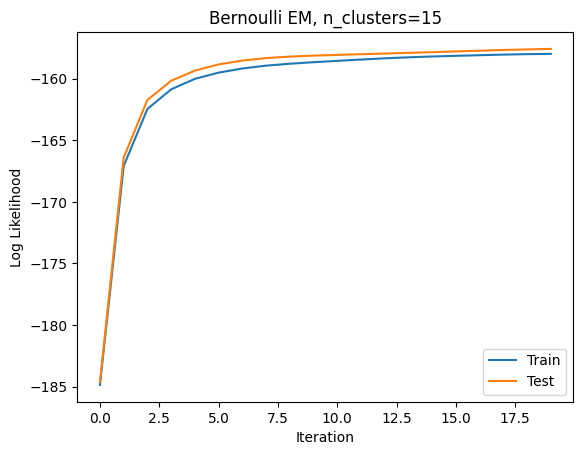

In [30]:
plt.plot(train_lls)
plt.plot(test_lls)
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.title('Bernoulli EM, n_clusters={}'.format(n_clusters))
plt.legend(('Train', 'Test'))

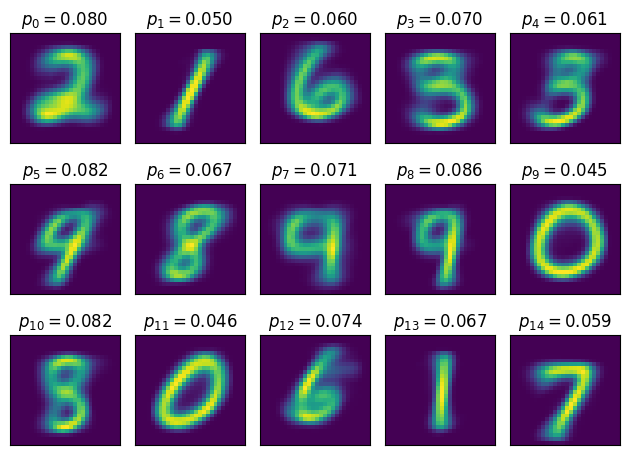

In [31]:
# display
n_rows = 3
n_cols = 5

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols)
for row_idx in range(n_rows):
    for col_idx in range(n_cols):
        ax = axs[row_idx][col_idx]
        cluster_idx = row_idx * n_cols + col_idx
        ax.imshow(params.cluster_means[cluster_idx].reshape((28, 28)))
        ax.xaxis.set_ticklabels([])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.yaxis.set_ticks([])
        ax.set_title("$p_{{{}}}={:.3f}$".format(cluster_idx, params.cluster_weights[cluster_idx]))

plt.tight_layout()

In [32]:
# for each datapoint, compute a hard assignment 
train_assignments = np.argmax(log_joint_prob(params, train_binary_images), axis=-1)
test_assignments = np.argmax(log_joint_prob(params, test_binary_images), axis=-1)

In [33]:
def make_cluster_labels(assignments, labels): 
    cluster_labels = [{} for _ in range(n_clusters)]
    for cluster_assignment, true_label in zip(assignments, labels):
        d = cluster_labels[cluster_assignment]
        d[true_label] = d.get(true_label, 0) + 1
    return cluster_labels

train_cluster_labels = make_cluster_labels(train_assignments, train_labels)
test_cluster_labels = make_cluster_labels(test_assignments, test_labels)

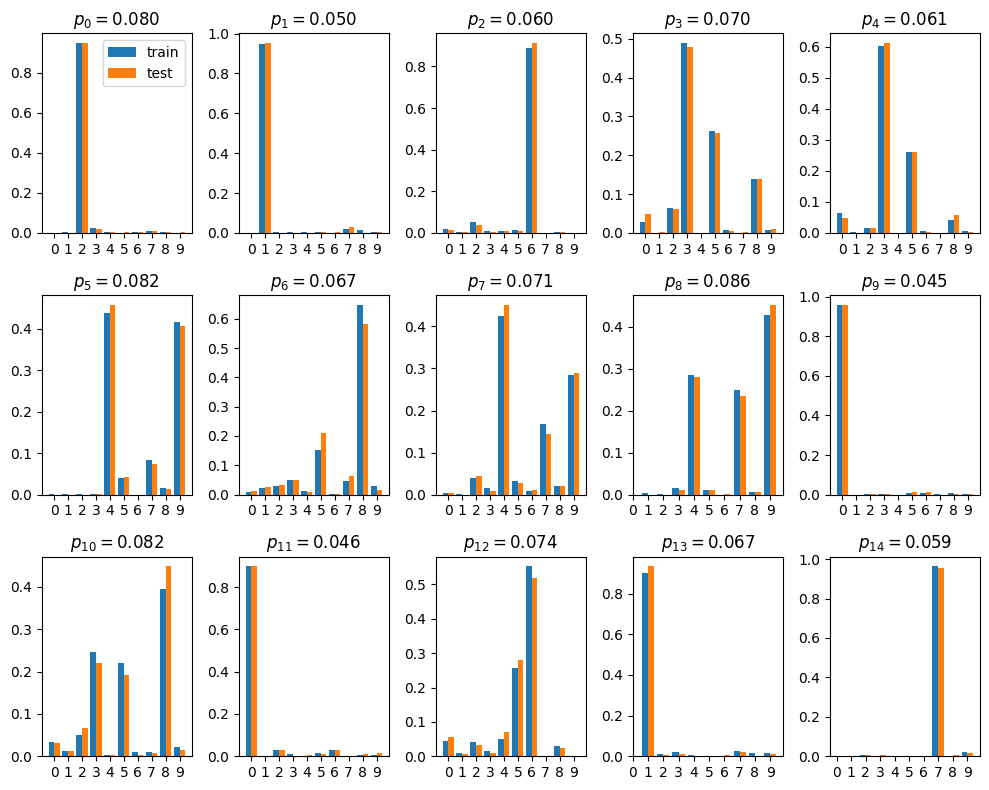

In [34]:
# display
n_rows = 3
n_cols = 5

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 8))
for row_idx in range(n_rows):
    for col_idx in range(n_cols):
        ax = axs[row_idx][col_idx]
        cluster_idx = row_idx * n_cols + col_idx
        labels = np.array([l for l, _ in train_cluster_labels[cluster_idx].items()])
        counts = np.array([v for _, v in train_cluster_labels[cluster_idx].items()])
        ax.bar(labels - 0.2, counts / np.sum(counts), width=0.4)
        labels = np.array([l for l, _ in test_cluster_labels[cluster_idx].items()])
        counts = np.array([v for _, v in test_cluster_labels[cluster_idx].items()])
        ax.bar(labels + 0.2, counts / np.sum(counts), width=0.4)
        ax.xaxis.set_ticks(list(range(10)))
        if cluster_idx == 0:
            ax.legend(('train', 'test'))
        ax.set_title("$p_{{{}}}={:.3f}$".format(cluster_idx, params.cluster_weights[cluster_idx]))

plt.tight_layout()

In [ ]:
### Generate

